In [1]:
using SciBmad
include("../../lattices/RCSV5S0.jl");
tw = twiss(ring)

Twiss:
 coasting_beam = false
 tunes[1:3]    = [Qx, Qy]
 table         has columns: beamline_index, name, s, phi_1, beta_1, alpha_1, phi_2, beta_2, alpha_2, phi_3, eta_1, etap_1, eta_2, etap_2, zeta_1, zetap_1, zeta_2, zetap_2, slip, gamma_c, c11, c12, c21, c22, orbit_x, orbit_px, orbit_y, orbit_py, orbit_z, orbit_pz

In [2]:
tw.tunes

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.130001699797837
  0.2100011257133925
 -0.02074470822459975

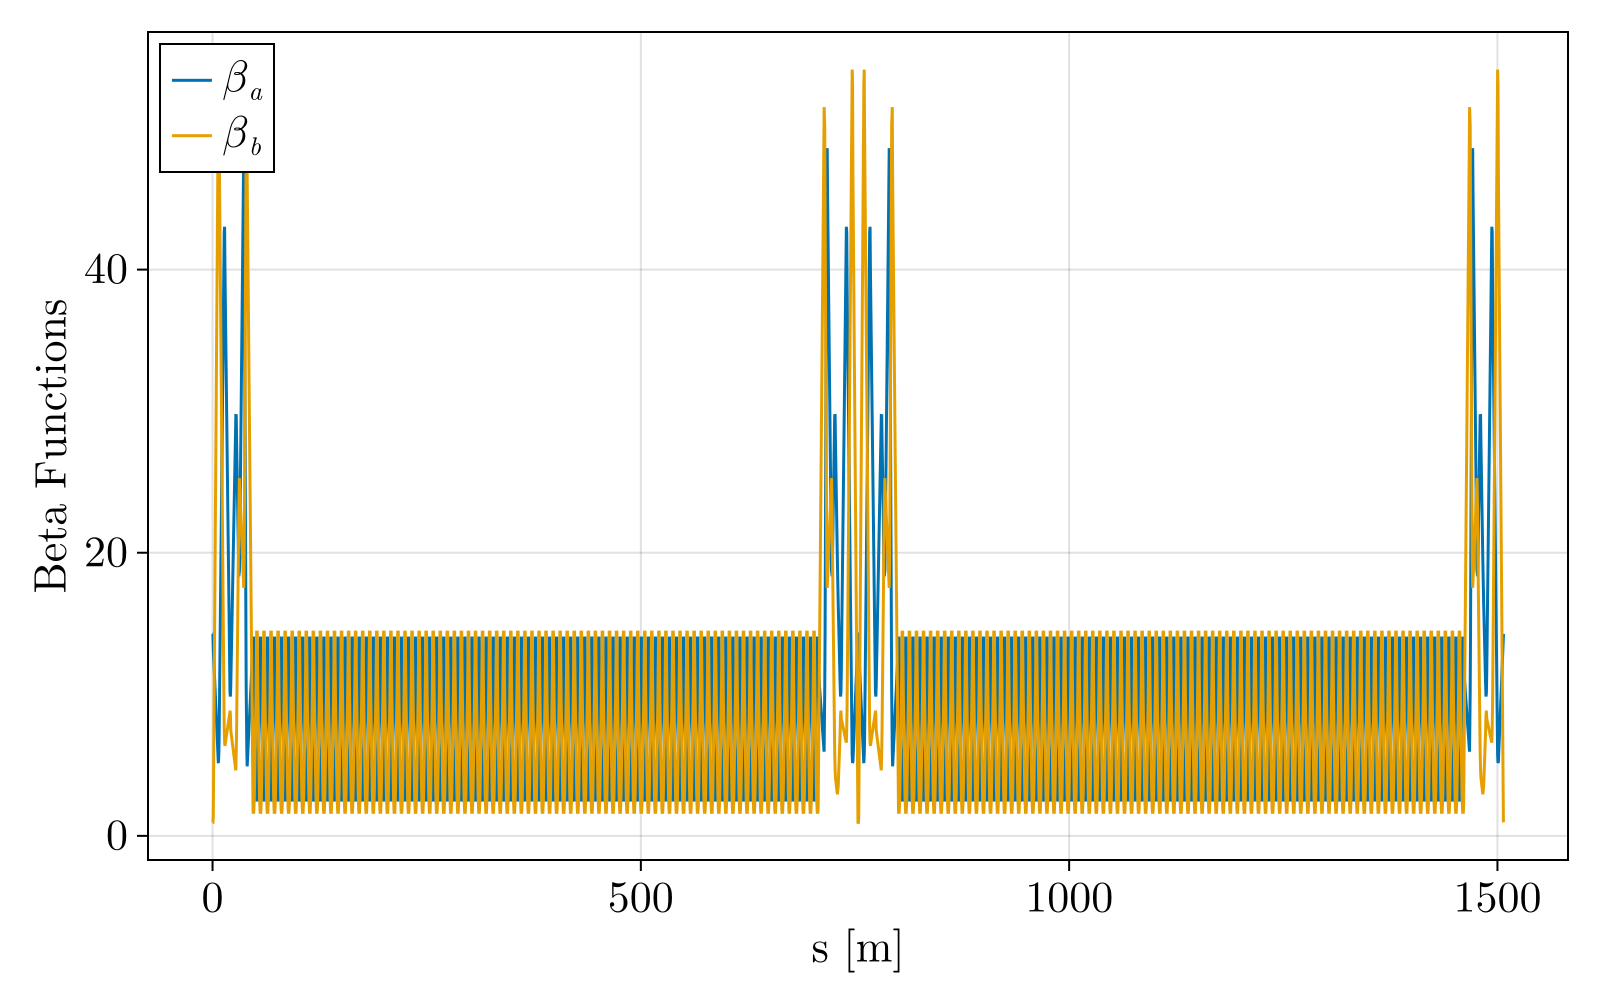

In [3]:
# Plot the betas
using CairoMakie
t = tw.table
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Beta Functions");
    lines!(ax, t.s, t.beta_1, label=L"\beta_a"); # L".." specifies a LaTeX string
    lines!(ax, t.s, t.beta_2, label=L"\beta_b");
    axislegend(position=:lt);
    display(f);
end;

In [4]:
# Let's see the linear closed orbit response as a function of
# e.g. qf_1 y_alignment and b0_1 tilt (2 PARAMETERS)
const DPARAMS1 = Descriptor(6, 1, 2, 1) # 6 dynamic variables to 1st order, 2 parameters to 1st order
Δk = params(DPARAMS1)
qf_1.y_offset = Δk[1] # make y_offset a parameter
b0_1.tilt = Δk[2]      # make tilt a parameter
tw = twiss(ring; GTPSA_descriptor=DPARAMS1)
t = tw.table;

In [5]:
# Closed orbit is now a Taylor series in the parameters:
# E.g. at the first element:
t.orbit_y[1]

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=1, NP=2, PO=1)
 COEFFICIENT             ORDER   EXPONENTS
-3.4019915158353969E-01    1     0 0  0 0  0 0  7^1
-3.4327120775750210E-02    1     0 0  0 0  0 0  8^1


This says that $\frac{\partial y_{co}}{\partial(\textrm{y\_offset})} = -2.7843532447442293\times 10^{-1}$ and $\frac{\partial y_{co}}{\partial(\textrm{tilt})} = -3.5426682007214952\times 10^{-2}$.
See the orbit response around the ring:

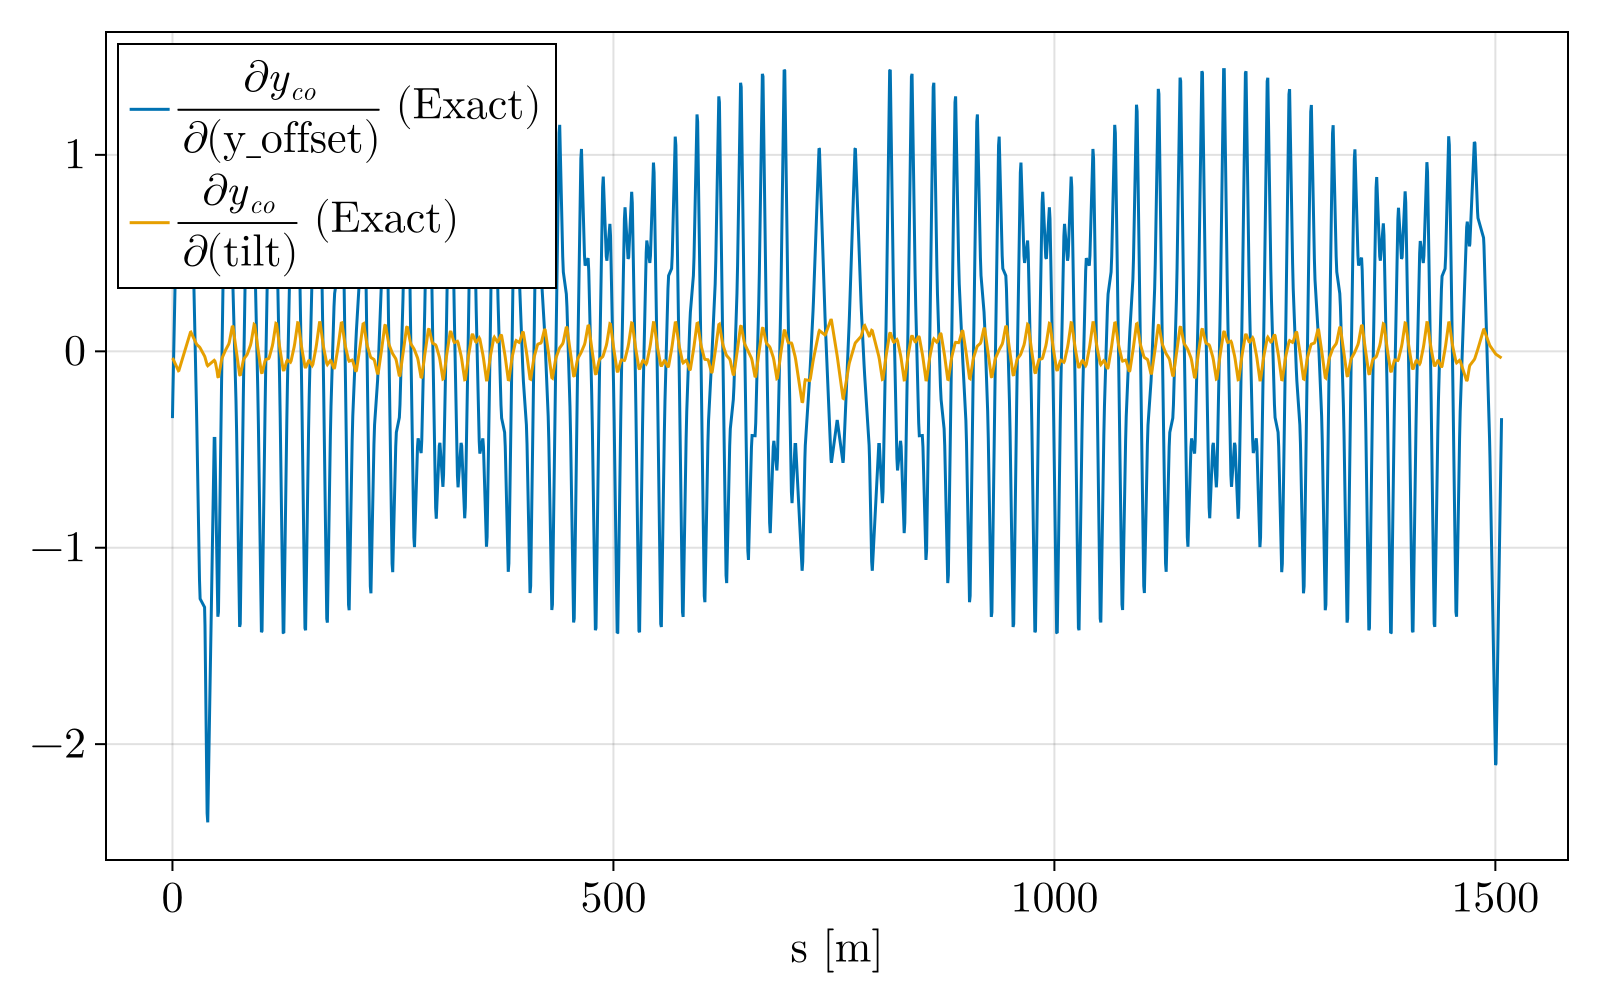

In [6]:
dy_dy_offset = map(x->x[[0,0,0,0,0,0,1]], t.orbit_y)
dy_dtilt = map(x->x[[0,0,0,0,0,0,0,1]], t.orbit_y)

# Plot the response around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]");
    lines!(ax, t.s, dy_dy_offset, label=L"\frac{\partial y_{co}}{\partial(\textrm{y\_offset})}\ \textrm{(Exact)}"); # L".." specifies a LaTeX string
    lines!(ax, t.s, dy_dtilt, label=L"\frac{\partial y_{co}}{\partial(\textrm{tilt})}\ \textrm{(Exact)}");
    axislegend(position=:lt);
    display(f);
end;

Now let's compare to finite differencing:

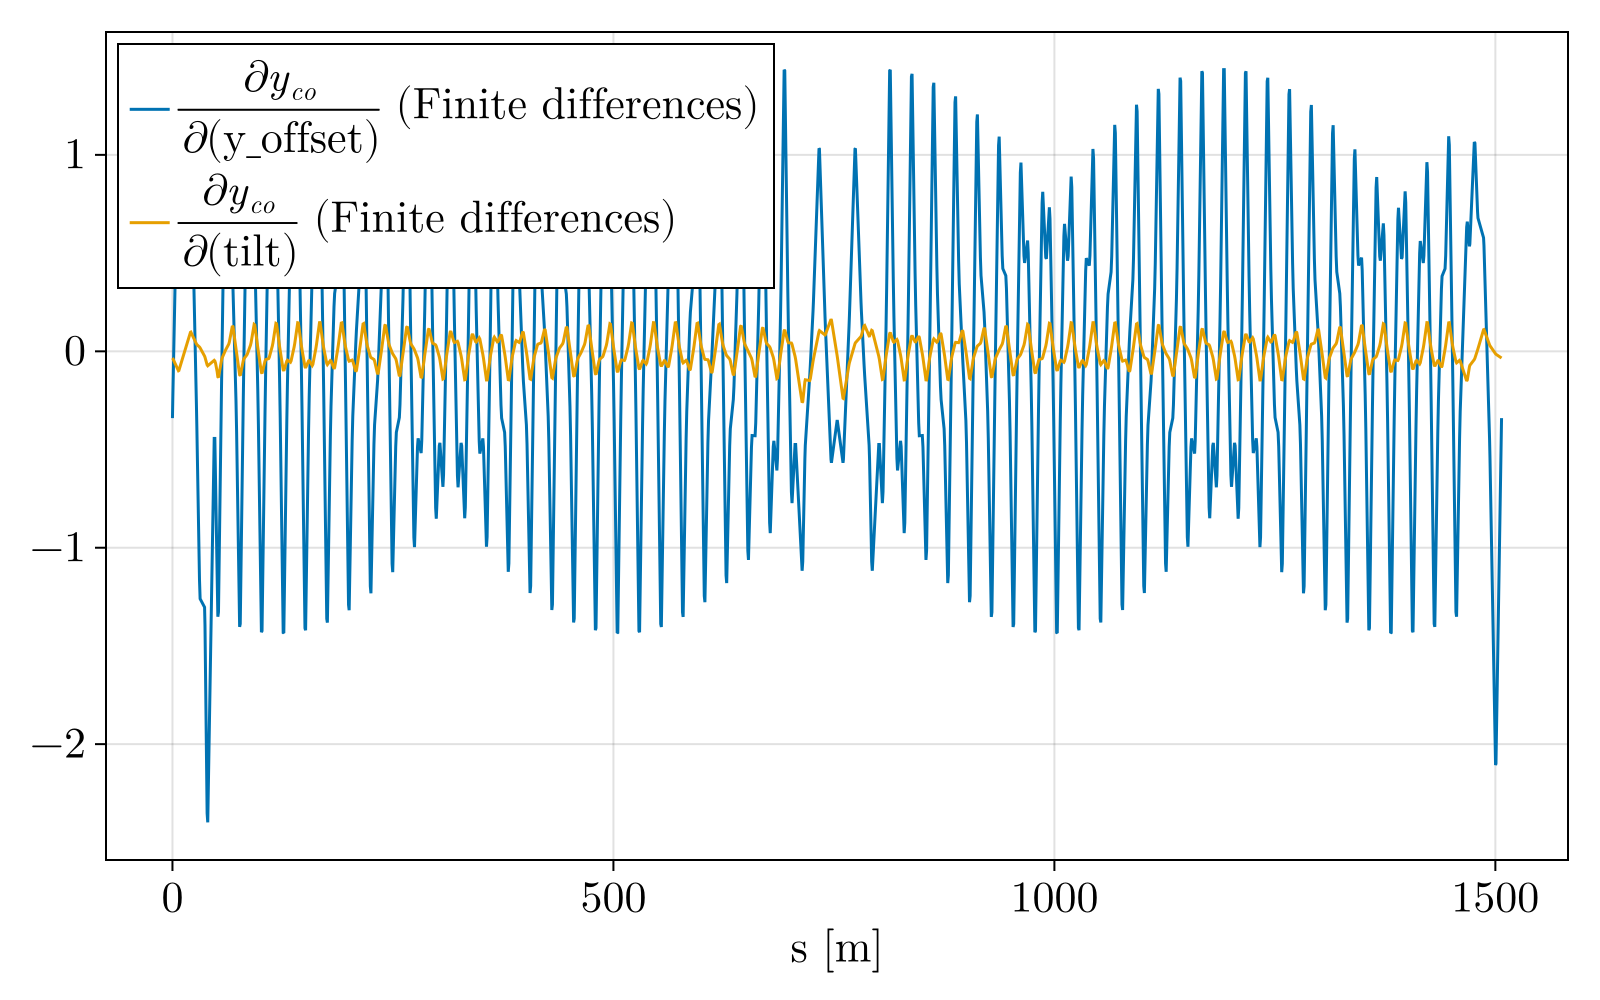

In [8]:
# First get rid of TPSA parameters in ring:
scalarize!(ring)

# Now set up finite differences:
step = 1e-6

# First dy/dy_offset
qf_1.y_offset = step
b0_1.tilt = 0
t = twiss(ring).table
# scalar gets zeroth order part
dy_dy_offset_FD = scalar.(t.orbit_y)/step

# Now dy/dtilt:
qf_1.y_offset = 0
b0_1.tilt = step
t = twiss(ring).table
dy_dtilt_FD = scalar.(t.orbit_y)/step

# And plot:
# Plot the response around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]");
    lines!(ax, t.s, dy_dy_offset_FD, label=L"\frac{\partial y_{co}}{\partial(\textrm{y\_offset})}\ \textrm{(Finite differences)}"); # L".." specifies a LaTeX string
    lines!(ax, t.s, dy_dtilt_FD, label=L"\frac{\partial y_{co}}{\partial(\textrm{tilt})}\ \textrm{(Finite differences)}");
    axislegend(position=:lt);
    display(f);
end;

Finite differences is usually ok for first order derivatives, but suffers significant error beyond that. Thanks to SciBmad's automatic differentiability, we can exactly compute the nonlinear derivatives. Simply specify a higher order for the GTPSA `Descriptor` and follow the same procedure above.